# MANUAL RNN

In [119]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [120]:
# CONSTANTS

In [121]:
num_inputs = 2

In [122]:
num_neurons = 3

In [123]:
# PLACEHOLDERS
x0 = tf.placeholder(tf.float32, [None, num_inputs])

In [124]:
x1 = tf.placeholder(tf.float32, [None, num_inputs])

In [125]:
# VARIABLES

In [126]:
Wx = tf.Variable(tf.random_normal(shape=[num_inputs, num_neurons]))

In [127]:
Wy = tf.Variable(tf.random_normal(shape=[num_neurons, num_neurons]))

In [128]:
b = tf.Variable(tf.zeros([num_neurons]))

In [129]:
# GRAPHS

In [130]:
y0 = tf.tanh(tf.matmul(x0, Wx) + b)

In [131]:
y1 = tf.tanh(tf.matmul(y0, Wy) + tf.matmul(x1, Wx)+ b)

In [132]:
init = tf.global_variables_initializer()

In [133]:
# CREATE DATA

In [134]:
#TIMESTAMP 0
x0_batch = np.array([[0, 1], [2, 3], [4, 5]])

#TIMESTAMP 1
x1_batch = np.array([[100, 101], [102, 103], [104, 105]])

In [135]:
with tf.Session() as sess:
    
    sess.run(init)
    
    y0_output_vals, y1_output_vals = sess.run([y0, y1], feed_dict={x0:x0_batch, x1:x1_batch})

In [136]:
y0_output_vals

array([[ 0.6982049 , -0.5605526 , -0.18295185],
       [ 0.9011177 , -0.8352006 , -0.03075059],
       [ 0.97001076, -0.944322  ,  0.12289024]], dtype=float32)

In [137]:
y1_output_vals

array([[ 1.        , -1.        ,  0.99999994],
       [ 1.        , -1.        ,  1.        ],
       [ 1.        , -1.        ,  1.        ]], dtype=float32)

# API

## DATA

In [138]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

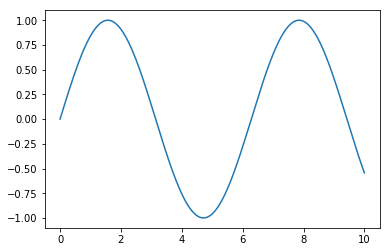

In [139]:
class TimeSeriesData():
    def __init__(self,num_points,xmin,xmax):
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.y_true = np.sin(self.x_data)
    
    def ret_true(self,x_series):
        return np.sin(x_series)
    
    def next_batch(
        self,batch_size,steps,return_batch_ts=False):
        # Grab a random starting point for each batch
        rand_start = np.random.rand(batch_size,1) 
        # Convert to be on time series
        ts_start = rand_start * (
            self.xmax- self.xmin - (steps*self.resolution) )
        # Create batch Time Series on t axis
        batch_ts = ts_start + np.arange(0.0,steps+1) * self.resolution
        # Create Y data for time series in the batches
        y_batch = np.sin(batch_ts)
        # Format for RNN
        if return_batch_ts:
            return y_batch[:, :-1].reshape(
                -1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) ,batch_ts
        else:
            return y_batch[:, :-1].reshape(
                -1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 
        
ts_data = TimeSeriesData(250,0,10)
plt.plot(ts_data.x_data,ts_data.y_true)

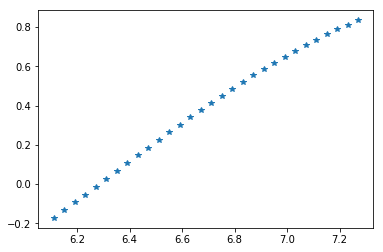

In [140]:
# Num of steps in batch (also used for prediction steps into the future)
num_time_steps = 30
y1,y2,ts = ts_data.next_batch(1,num_time_steps,True)
plt.plot(ts.flatten()[1:],y2.flatten(),'*')

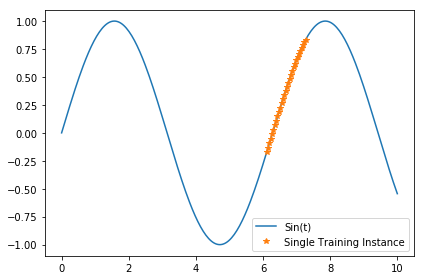

In [141]:
plt.plot(ts_data.x_data,ts_data.y_true,label='Sin(t)')
plt.plot(ts.flatten()[1:],y2.flatten(),'*',label='Single Training Instance')
plt.legend()
plt.tight_layout()

In [142]:
train_inst = np.linspace(5,5 + ts_data.resolution * 
                         (num_time_steps + 1), num_time_steps+1)

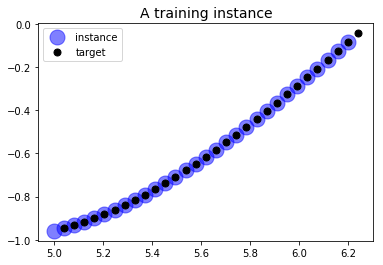

In [143]:
plt.title("A training instance", fontsize=14)
plt.plot(train_inst[:-1], ts_data.ret_true(
    train_inst[:-1]), "bo", markersize=15,alpha=0.5 ,label="instance")
plt.plot(train_inst[1:], ts_data.ret_true(
    train_inst[1:]), "ko", markersize=7, label="target")
plt.legend()

## CREATE THE MODEL

In [144]:
tf.reset_default_graph()
# Just one feature, the time series
num_inputs = 1
# 100 neuron layer, play with this
num_neurons = 100
# Just one output, predicted time series
num_outputs = 1
# learning rate, 0.0001 default, 
#but you can play with this
learning_rate = 0.0001
# how many iterations to go through 
#(training steps), you can play with this
num_train_iterations = 2000
# Size of the batch of data
batch_size = 1

In [145]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [146]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs)
"""
cell = tf.contrib.rnn.OutputProjectionWrapper(
     tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu),
     output_size=num_outputs)    

n_neurons = 100
n_layers = 3

cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
           for layer in range(n_layers)])

cell = tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu)

n_neurons = 100
n_layers = 3

cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
           for layer in range(n_layers)])
"""

'\ncell = tf.contrib.rnn.OutputProjectionWrapper(\n     tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu),\n     output_size=num_outputs)    \n\nn_neurons = 100\nn_layers = 3\n\ncell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)\n           for layer in range(n_layers)])\n\ncell = tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu)\n\nn_neurons = 100\nn_layers = 3\n\ncell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)\n           for layer in range(n_layers)])\n'

In [147]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [148]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [149]:
init = tf.global_variables_initializer()

In [150]:
# ONLY FOR GPU USERS:
# https://stackoverflow.com/questions/34199233/
# how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)
saver = tf.train.Saver()
with tf.Session(config=tf.ConfigProto()) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, "./rnn_time_series_model")

0 	MSE: 0.6077745
100 	MSE: 0.0391928
200 	MSE: 0.02080634
300 	MSE: 0.026717689
400 	MSE: 0.0011097784
500 	MSE: 0.010567269
600 	MSE: 0.010287553
700 	MSE: 0.016830124
800 	MSE: 0.015447638
900 	MSE: 0.00978098
1000 	MSE: 0.0020551288
1100 	MSE: 0.0023367081
1200 	MSE: 0.0056983563
1300 	MSE: 0.0004409944
1400 	MSE: 0.0020108717
1500 	MSE: 0.00026613235


KeyboardInterrupt: 

In [ ]:
with tf.Session() as sess:                          
    saver.restore(sess, "./rnn_time_series_model")   

    X_new = np.sin(np.array(train_inst[:-1].reshape(-1, num_time_steps, num_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
plt.title("Testing Model")
# Training Instance
plt.plot(train_inst[:-1], np.sin(
    train_inst[:-1]), "bo", markersize=15,alpha=0.5, label="Training Instance")
# Target to Predict
plt.plot(train_inst[1:], np.sin(train_inst[1:]), "ko", markersize=10, label="target")
# Models Prediction
plt.plot(train_inst[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()

## GENERATE NEW DATA

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_time_series_model")
    # SEED WITH ZEROS
    zero_seq_seed = [0. for i in range(num_time_steps)]
    for iteration in range(len(ts_data.x_data) - num_time_steps):
        X_batch = np.array(
            zero_seq_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        zero_seq_seed.append(y_pred[0, -1, 0])
        
plt.plot(ts_data.x_data, zero_seq_seed, "b-")
plt.plot(ts_data.x_data[:num_time_steps], 
         zero_seq_seed[:num_time_steps], "r", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_time_series_model")
    # SEED WITH Training Instance
    training_instance = list(ts_data.y_true[:30])
    for iteration in range(len(ts_data.x_data) -num_time_steps):
        X_batch = np.array(
            training_instance[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        training_instance.append(y_pred[0, -1, 0])
        
plt.plot(ts_data.x_data, training_instance, "b-")
plt.plot(ts_data.x_data[:num_time_steps],
         training_instance[:num_time_steps], "r-", linewidth=3)
plt.xlabel("Time")

# WORD2VEC

In [151]:
import collections
import math
import os
import errno
import random
import zipfile
import numpy as np
from six.moves import urllib
from six.moves import xrange 
import tensorflow as tf

In [152]:
data_dir = "word2vec_data/words"
data_url = 'http://mattmahoney.net/dc/text8.zip'

def fetch_words_data(url=data_url, words_data=data_dir):
    # Make the Dir if it does not exist
    os.makedirs(words_data, exist_ok=True)
    # Path to zip file 
    zip_path = os.path.join(words_data, "words.zip")
    # If the zip file isn't there, download it from the data url
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(url, zip_path)
    # Now that the zip file is there, get the data from it
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    # Return a list of all the words in the data source.
    return data.decode("ascii").split()

# Use Defaults (this make take awhile!!)
words = fetch_words_data()
# Random slice of words
for w in words[9000:9014]:
    print(w,end=' ')

feelings and the auditory system of a person without autism often cannot sense the 

In [153]:
from collections import Counter
mylist = ["one",'one','two']
Counter(mylist).most_common(1)

[('one', 2)]

In [154]:
def create_counts(vocab_size=50000):
    # Begin adding vocab counts with Counter
    vocab = [] + Counter(words).most_common(vocab_size )
    # Turn into a numpy array
    vocab = np.array([word for word, _ in vocab])
    dictionary = {word: code for code, word in enumerate(vocab)}
    data = np.array([dictionary.get(word, 0) for word in words])
    return data,vocab, dictionary


# This may take awhile
data,vocabulary,dictionary = create_counts(vocab_size=vocab_size)

In [155]:
data.shape

(17005207,)

In [156]:
(words[100],data[100])

('interpretations', 4187)

In [157]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
    if data_index == len(data):
        buffer[:] = data[:span]
        data_index = span
    else:
        buffer.append(data[data_index])
        data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels
data_index=0
batch, labels = generate_batch(8, 2, 1)

In [164]:
# Size of the bath
batch_size = 128

# Dimension of embedding vector
embedding_size = 150

# How many words to consider left and right (the bigger, the longer the training)
skip_window = 1       

# How many times to reuse an input to generate a label
num_skips = 2      

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.

# Random set of words to evaluate similarity on.
valid_size = 16   

# Only pick dev samples in the head of the distribution.
valid_window = 100  
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

# Number of negative examples to sample.
num_sampled = 64   

# Model Learning Rate
learning_rate = 0.01

# How many words in vocab
vocabulary_size = 50000

In [165]:
tf.reset_default_graph()
# Input data.
train_inputs = tf.placeholder(tf.int32, shape=[None])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [166]:
# Look up embeddings for inputs.
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [167]:
# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.truncated_normal(
        [vocabulary_size, embedding_size],stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

In [168]:
# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=1.0)
trainer = optimizer.minimize(loss)
# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
# Add variable initializer.
init = tf.global_variables_initializer()

In [171]:
# Usually needs to be quite large to get good results, 
# training takes a long time!
num_steps = 5000
with tf.Session(config=tf.ConfigProto()) as sess:
    sess.run(init)
    average_loss = 0
    for step in range(num_steps):       
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}
        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        empty, loss_val = sess.run([trainer, loss], feed_dict=feed_dict)
        average_loss += loss_val
        if step % 1000 == 0:
            if step > 0:
                average_loss = average_loss / 1000
            # The average loss is an estimate of the loss over the last 1000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0
    final_embeddings = normalized_embeddings.eval()

Average loss at step  0 :  291.8880615234375
Average loss at step  1000 :  9422.759684173583
Average loss at step  2000 :  19939.09272803497
Average loss at step  3000 :  22287.23786734009
Average loss at step  4000 :  28048.5430059824


In [172]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


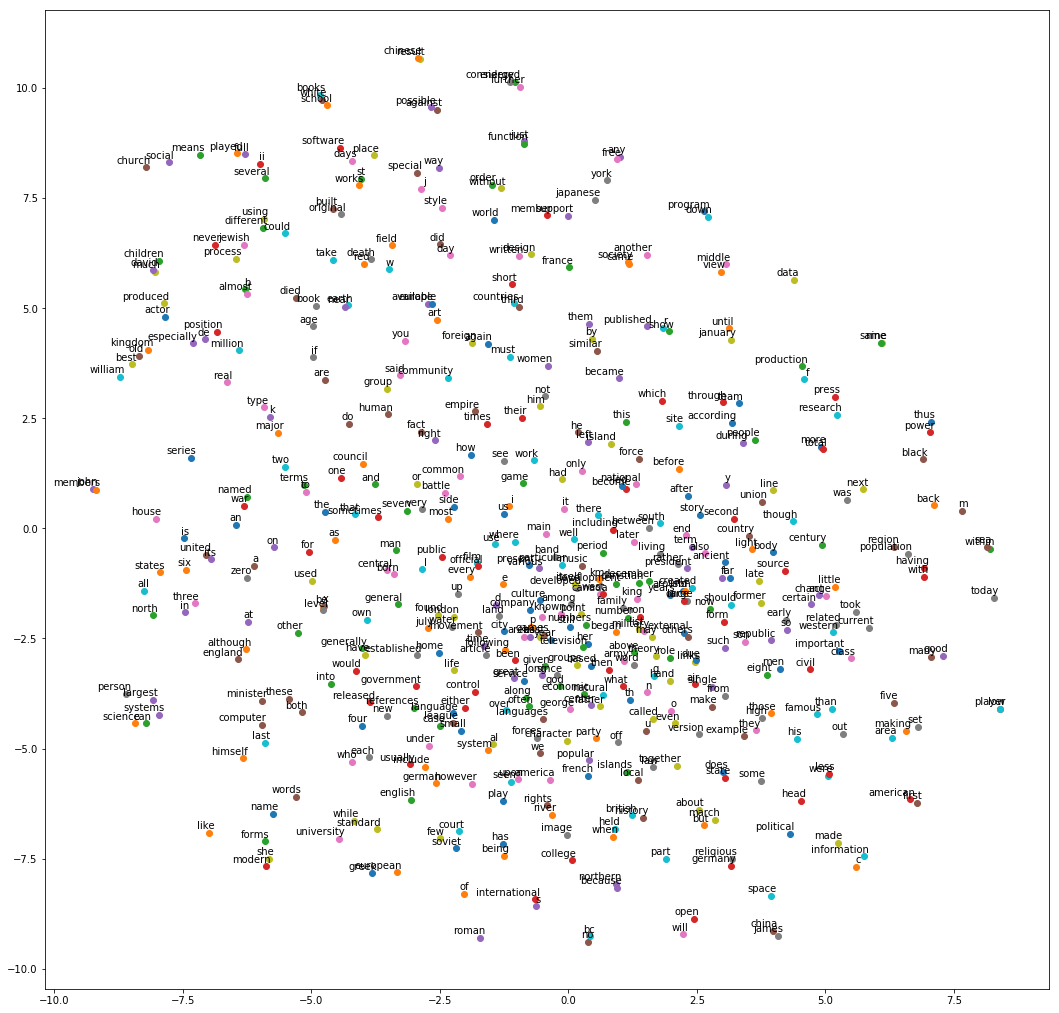

In [173]:
from  sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

(-10, 10)

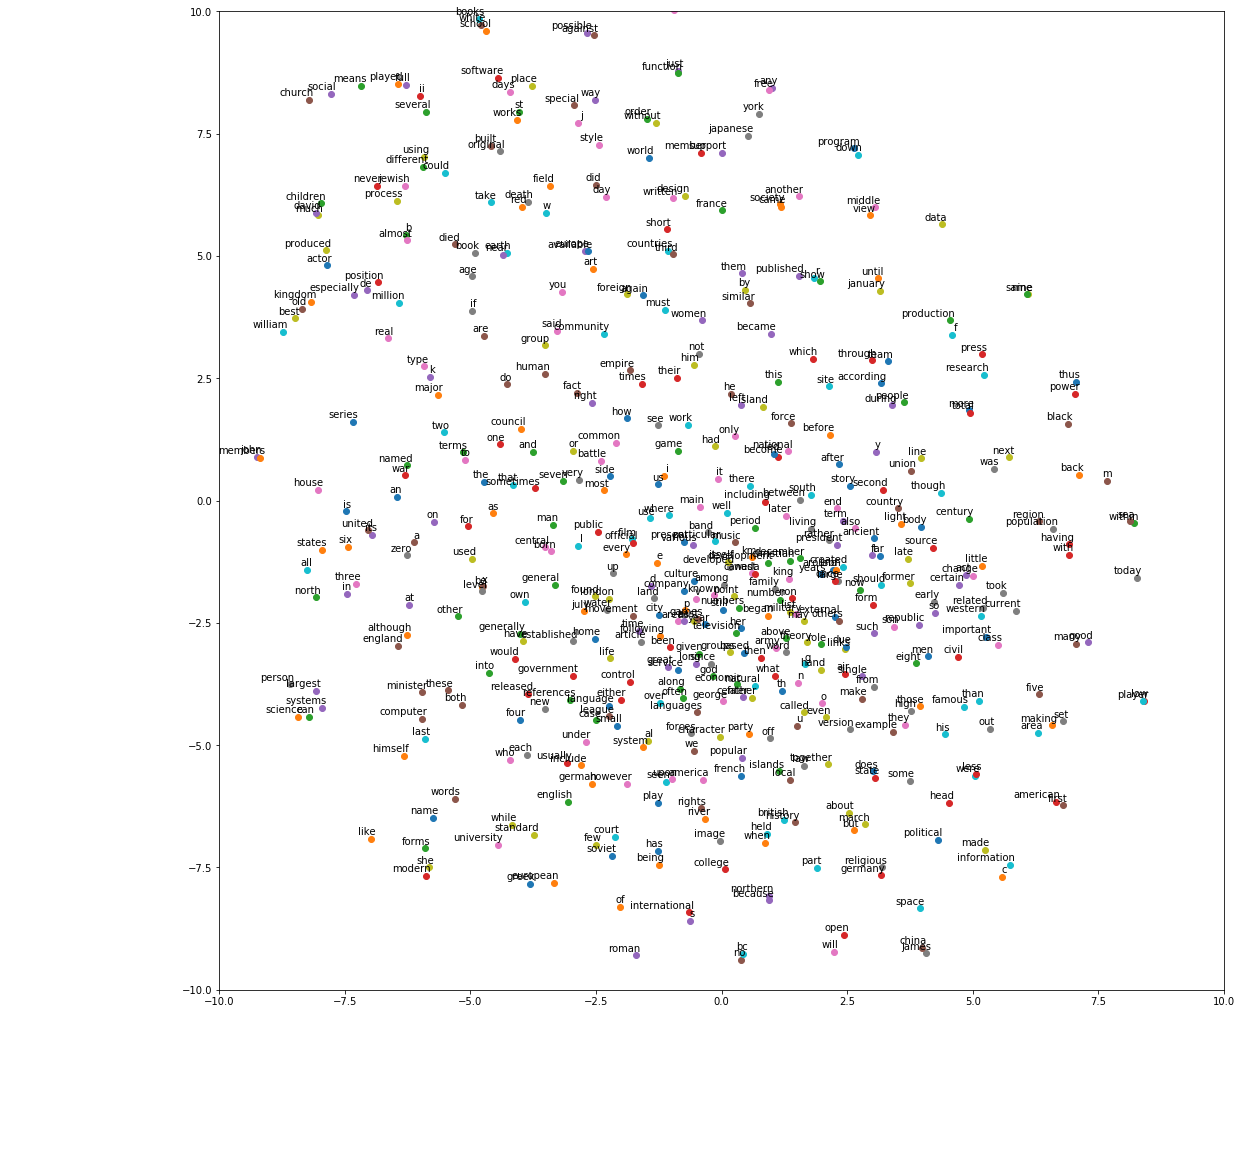

In [174]:
plot_with_labels(low_dim_embs, labels)
plt.xlim(-10,10)
plt.ylim(-10,10)